# Bit-flip repetition code

To enable real-time quantum error correction (QEC), we require the capability to dynamically control quantum program flow during execution so that quantum gates may be conditioned on measurement results. In this tutorial, we will run the bit-flip code, which is a very simple form of QEC. We will demonstrate a dynamic quantum circuit that can protect an encoded qubit from a single bit-flip error, and then evaluate the performance of the bit-flip code.

In [1]:
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

import warnings

warnings.filterwarnings("ignore")

Make sure to update the ``hub/group/provider/backend_name`` below.

In [2]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

hub = "<hub>"
group = "<group>"
project = "<project>"
hgp = f"{hub}/{group}/{project}"
backend_name = "<backend name>"

backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using {backend.name}")

In [3]:
shots: int = 1000  # Number of shots to run each circuit for

## Run basic quantum error correction

*Note*: This tutorial draws heavily from the excellent tutorials [1](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html) and [2](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_quantum_2018/intro2qc/10.Quantum%20error%20correction.ipynb).

A few more excellent references for an introduction to quantum error correction are [3](https://www2.physics.ox.ac.uk/sites/default/files/ErrorCorrectionSteane06.pdf), [4](https://arxiv.org/abs/1907.11157), [5](https://arxiv.org/abs/0905.2794), and [6](https://www.nature.com/articles/s41534-020-00304-y).

### The basics of error correction

The basic ideas behind error correction are the same for quantum information as for classical information. We can therefore begin by considering a very straightforward example: speaking on the phone. If someone asks you a question to which the answer is 'yes' or 'no', the way you give your response will depend on two factors:

* How important is it that you are understood correctly?
* How good is your connection?

Both of these can be parameterized with probabilities. For the first, we can use $P_a$, the maximum acceptable probability of being misunderstood. If you are being asked to confirm a preference for ice cream flavors, and don't mind too much if you get vanilla rather than chocolate, $P_a$ might be quite high. If you are being asked a question on which someone's life depends, however, $P_a$ will be much lower.


For the second we can use $p$, the probability that your answer is garbled by a bad connection. For simplicity, let's imagine a case where a garbled 'yes' doesn't simply sound like nonsense, but sounds like a 'no'. Similarly, a 'no' is transformed into 'yes'. Then $p$ is the probability that you are completely misunderstood.

A good connection or a relatively unimportant question will result in $p<P_a$. In this case it is fine to simply answer in the most direct way possible: you just say 'yes' or 'no'.

If, however, your connection is poor and your answer is important, then $p>P_a$. A single 'yes' or 'no' is not enough in this case. The probability of being misunderstood would be too high. Instead we must encode our answer in a more complex structure, allowing the receiver to decode our meaning despite the possibility that the message is disrupted. The simplest method is the one that many would do without thinking: simply repeat the answer many times; for example, say 'yes, yes, yes' instead of 'yes' or 'no, no, no' instead of 'no'.

If the receiver hears 'yes, yes, yes' in this case, they will of course conclude that the sender meant 'yes'. If they hear 'no, yes, yes', 'yes, no, yes' or 'yes, yes, no', they will probably conclude the same thing, since there is more positivity than negativity in the answer. To be misunderstood in this case, at least two of the replies need to be garbled. The probability for this, $P$, will be less than $p$. When encoded in this way, the message therefore becomes more likely to be understood. The code cell below shows an example of this.

In [4]:
p1 = 0.01
p3 = 3 * p1**2 * (1 - p1) + p1**3  # probability of 2 or 3 errors
print("Probability of a single reply being garbled: {}".format(p1))
print("Probability of a majority of the three replies being garbled: {:.4f}".format(p3))

Probability of a single reply being garbled: 0.01
Probability of a majority of the three replies being garbled: 0.0003


Say $P_a=p1$, that our acceptance probability is just at the threshold of a single garbled reply. With the majority voting technique above, $p3<P_a$, and this technique solves our problem. If it had not, then we can simply add more repetitions. The fact that $p3<P_a$ above comes from the fact that we need at least two replies to be garbled to flip the majority, and so even the most likely possibilities have a probability of $\sim p1^2$. For five repetitions we'd need at least three replies to be garbled to flip the majority, which happens with probability $\sim p1^3$. The value for $P$ in this case would then be even lower. Indeed, as we increase the number of repetitions, $P$ will decrease exponentially. No matter how bad the connection, or how certain we need to be of our message getting through correctly, we can achieve it by just repeating our answer enough times.

Though this is a simple example, it contains all the aspects of error correction.
* There is some information to be sent or stored: in this case, a 'yes' or 'no'.
* The information is encoded in a larger system to protect it against noise: in this case, by repeating the message.
* The information is finally decoded, mitigating the effects of noise: in this case, by trusting the majority of the transmitted messages.

This same encoding scheme can also be used for binary, by simply substituting `0` and `1` for 'yes' and 'no'. It can therefore also be easily generalized to qubits by using the states $\left|0\right\rangle$ and $\left|1\right\rangle$. In each case it is known as the *repetition code*. Many other forms of encoding are also possible in both the classical and quantum cases, which outperform the repetition code in many ways; however, its status as the simplest encoding lends it to certain applications.

## Quantum error correction

While repetition conceptually underlies the codes in this notebook, implementing the repetition code naively will not allow us to store *quantum information*. This is because the very act of measuring our data qubits will destroy the encoded state. For example, consider that we encoded the state $|\Psi_0\rangle = \alpha |0\rangle + \beta |1\rangle$ as $|\tilde{\Psi}_0\rangle = \alpha |000\rangle + \beta |111\rangle$. If we measure all of the qubits according to the Born rule, we will obtain the outcome states with probability $Pr(|000\rangle) = |\alpha|^2$ and $Pr(|111\rangle) = |\beta|^2$. 


If we then decode our encoded state $|\tilde{\Psi}_1\rangle \rightarrow |\Psi_1\rangle$ we will obtain

$$
  |\Psi_1\rangle =
\begin{cases}
|0\rangle & \propto Pr(|000\rangle) = |\alpha|^2\\
|1\rangle & \propto Pr(|111\rangle) = |\beta|^2
\end{cases}
$$

Importantly this is **not** the state we encoded $|\Psi_0\rangle$. This is because our measurement operation *does not commute with the encoding of the state*.

This might appear to imply that quantum error correcting codes are not possible. However, it turns out we can exploit additional ancilla qubits and entanglement to measure what are known as *stabilizers* that do not transform our encoded quantum information, while still informing us of some classes of errors that may have occurred. 

## Stabilizer codes

A quantum stabilizer code encodes $k$ logical qubits into $n$ physical qubits. The coding rate is defined as the ratio of $k/n$. The *stabilizer* $S$ is an Abelian subgroup of the Pauli group $\Pi^n$ (importantly it does not matter in which order we apply our stabilizers). The +1 eigenspace of the stabilizer operators make up the *codespace* of the code. It will have dimension $2^k$ and can therefore encode $k$ qubits. 

Stabilizer codes critically focus on correcting a discrete error set with support from the Pauli group $\Pi^n$. Assume the set of possible errors are $ \epsilon \subset \Pi^n$. For example, in a bit-flip code with three qubits encoding the quantum state, we will have $\epsilon = \{IIX, IXI, XII\}$.

As both $S$ and $\epsilon$ are subsets of the Pauli group $\Pi^n$, if an error $E \in \epsilon$ is applied to a state it will either commute or anticommute with one of the generators of the stabilizer group $g \in S$. If the error anticommutes with a stabilizer element, it will be both detectable and correctable, as it will change the sign of the stabilizer measurement.

In general we can measure each element of the generator of the stabilizer (the minimal representation) $\{g_1, \cdots, g_{n-k} | \forall i \in \{1, \cdots, n-k\}, g_i \in S\}$, which produces a syndrome bitstring $\vec{x}$ where we assign `0` for a generator that commutes (+1 eigenspace) and `1` for a generator that anticommutes (-1 eigenspace). This is known as measuring the error *syndrome*.

If $E_a$ commutes with $g_i$:
$$g_iE_a|\tilde{\Psi}\rangle = E_ag_i|\tilde{\Psi}\rangle=E_a|\tilde{\Psi}\rangle$$

If $E_a$ anti-commutes with $g_i$:
$$g_iE_a|\tilde{\Psi}\rangle = -E_ag_i|\tilde{\Psi}\rangle=-E_a|\tilde{\Psi}\rangle$$


Measuring the stabilizer generators *will not* modify our encoded qubit, since by definition they commute with the codespace; however, *errors will* modify our encoded qubit.

## Correct errors

We now know how to *detect* an error (by measuring the stabilizers and observing their eigenvalues). 

The next step is to *decode* and *correct* the error.

The condition for recovery is either: (1) $E_a^\dagger E_b \in S$ or (2) there exists $M \in S$ that anticommutes with $E_a^\dagger E_b$. [For more details, see here.](http://theory.caltech.edu/~preskill/ph229/notes/chap7.pdf)

While the above is a mathematical introduction to stabilizer codes, we believe it
is better to learn the practicalities of implementing them with some hands-on practice.


### Stabilizer codes in practice
In general there is a common structure to most experiments with stabilizer codes. Someday we will write a *logical* program and have the hardware determine how to encode and decode syndromes to correct errors in the program. Today, we are just starting to explore the practical implementation of QEC. We therefore manually encode our logical state in *physical qubits* with circuits that we write at the physical qubit level. The typical flow to such an experiment is as follows:

1. Initialize our input physical state $|\Psi_0\rangle \rightarrow |\Psi_1\rangle$ we wish to protect.
2. Encode our state in our stabilizer's codespace as $|\Psi_1\rangle \rightarrow |\tilde{\Psi}_1\rangle$.
3. Apply an error channel. These may be simulated Krauss maps, probabilistically applied gates (as we demonstrate below), or simply the passive error channel in the device of interest. $|\tilde{\Psi_1}\rangle \rightarrow |\tilde{\Psi}_2\rangle$.
4. Measure the syndrome by measuring the generators of our stabilizer $\langle\tilde{\Psi}_2|g_0\cdots g_n|\tilde{\Psi}_2\rangle \rightarrow |\tilde{\Psi}_2\rangle,\ \  \vec{x}$.
5. Apply a decoding sequence $D(\vec{x})$ to our stabilizer and apply the correction sequence for the error (if possible) that we have decoded, $D(\vec{x})|\tilde{\Psi}_2\rangle \rightarrow |\tilde{\Psi}_1\rangle$. It is in computing $D(\vec{x})$ where dynamic circuit capabilities are important.
6. Loop to 3, if we are running multiple iterations of the stabilizer sequence.
7. Decode our encoded state to determine whether the encoded state was corrupted.
8. Measure the final data qubit to observe the state we protected and determine how well the code performed.

## Execute the bit-flip code on hardware

The bit-flip code is among the simplest examples of a stabilizer code. It can protect our state against a single bit-flip (X) error on any of the encoding qubits. If we consider the action of bit-flip error $X$ which maps $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |0\rangle$ on any of our qubits, we have $\epsilon = \{E_0, E_1, E_2 \} = \{IIX, IXI, XII\}$. The code requires five qubits: three are used to encode the protected state, and the remaining two are used as stabilizer measurement ancillas. Nonetheless, the ancillas are not counted, so this means our coding rate for this state is $1/3$.

In [5]:
# Setup a base quantum circuit for our experiments
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3)
creg_syndrome = ClassicalRegister(2)
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]


def build_qc() -> QuantumCircuit:
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

### Initialize our qubit
To protect a quantum state, we must first prepare it.
In general we can prepare the state $$|\Psi_0\rangle \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$$
In the circuit below we prepare the physical state $$|\Psi_1\rangle = |1\rangle$$

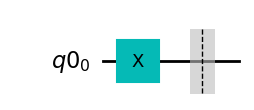

In [6]:
qc_init = build_qc()

qc_init.x(qreg_data[0])
qc_init.barrier(qreg_data)

qc_init.draw(output="mpl", idle_wires=False)

### Encode our logical state
To protect our qubit we must encode it in the codespace. For the case of the bit-flip code, this
is very similar to the repetition code, where we implement repetition using the entangling
`CX` gate rather than a classically conditioned bit-flip, as we would do in the classical case.

The encoding circuit below will map $|\Psi_1\rangle = U_{en}|\Psi_0\rangle = |00\rangle (\alpha |000\rangle + \beta |111\rangle)$.

The codespace of our bit-flip code is therefore $V_s = \{|000\rangle, |111\rangle\}$.

The stabilizers for the bit-flip code is $S = III, IZZ, ZIZ, ZZI$. 


Operationally, this means that a single bit-flip error applied to the qubits will modify the observed state of a stabilizer measurement, but leave it within the codespace. It is also straightforward to show that any two non-trivial stabilizer elements can generate the full stabilizer. For example, take the generator set $G_0 = \{g_0, g_1 \} = \{ IZZ, ZIZ \}$.

We see this as $g_0g_1 = IZZ.ZIZ = ZZI$ and $g_0g_0 = IZZ.IZZ = III$. completing our stabilizer.

This means that we must only measure our two generators $g_0$ and $g_1$ to detect any *correctable* error.

It is easy to see the prepared state is a +1 eigenstate of our stabilizers
$IZZ |\Psi_1\rangle = |\Psi_1\rangle$ 
$ZIZ |\Psi_2\rangle = |\Psi_2\rangle$. 

This is because the stabilizer measures the *parity* of the two target qubits.


The circuit below maps
$$|\Psi_1\rangle \rightarrow |\tilde{\Psi}_1\rangle$$

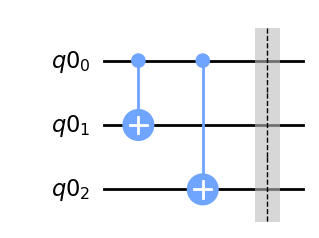

In [7]:
def encode_bit_flip(qc, state, ancillas):
    control = state
    for ancilla in ancillas:
        qc.cx(control, ancilla)
    qc.barrier(state, *ancillas)
    return qc


qc_encode_bit = build_qc()

encode_bit_flip(qc_encode_bit, state_data, ancillas_data)

qc_encode_bit.draw(output="mpl", idle_wires=False)

### Prepare a decoding circuit
To readout our final state we must map it back from the codespace to a single qubit.
For our code this is simply $U_{de} = U_{en}^\dagger$.

This will be used to map our state out of the codespace:
$$|\tilde{\Psi_1}\rangle \rightarrow |\Psi_1\rangle$$

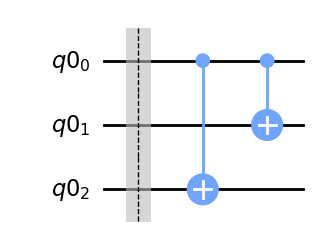

In [8]:
def decode_bit_flip(qc, state, ancillas):
    inv = qc_encode_bit.inverse()
    return qc.compose(inv)


qc_decode_bit = build_qc()

qc_decode_bit = decode_bit_flip(qc_decode_bit, state_data, ancillas_data)

qc_decode_bit.draw(output="mpl", idle_wires=False)

### A circuit that prepares our encoded state $|\tilde{\Psi}_1\rangle$

Below we see how we can combine the state preparation and encoding steps
to encode our state in the bit-flip code.

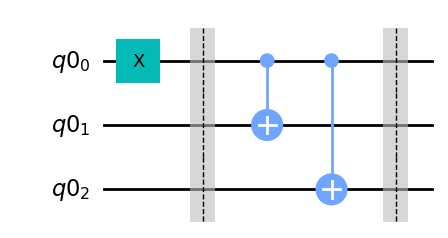

In [9]:
qc_encoded_state_bit = qc_init.compose(qc_encode_bit)
qc_encoded_state_bit.draw(output="mpl", idle_wires=False)

### Measure the syndome



If, however, we consider the action of bit-flip error $X$, which maps $|0\rangle \rightarrow |1\rangle$ and $|1\rangle -> |0\rangle$ on any of our qubits, we have $\epsilon = \{E_0, E_1, E_2 \} = \{IIX, IXI, XII\}$.


The circuit below measures the stabilizer $IZZ$ onto `creg_measure[0]` and $ZIZ$ onto `creg_measure[1]`. This effectively measures the parity of the two respective qubits in each stabilizer. 

- If we observe `IZZ= -1` an error ocurred on qubit 0 or 1
- If we observe `ZIZ= -1` an error ocurred on qubit 0 or 2

One important detail to note in the circuit below is that we *reset* our ancilla qubits after measuring the stabilizer. This is done so that we may reuse them for repeated stabilizer measurements. Also note we are making use of the fact that we have already observed the state of the qubit and are writing the conditional reset protocol
directly to avoid another round of qubit measurement if we used the `reset` instruction.

The circuit below will measure our stabilizers, generating a syndrome. We assume it is applied after some error channel $\Omega$ that takes $\Omega(|\tilde{\Psi_1}\rangle \langle\tilde{\Psi_1}|) = |\tilde{\Psi_2}\rangle \langle\tilde{\Psi_2}|$.
$$\langle \tilde{\Psi}_2|g_0\cdots g_n|\tilde{\Psi}_2\rangle \rightarrow |\tilde{\Psi}_2\rangle,\ \  \vec{x}$$

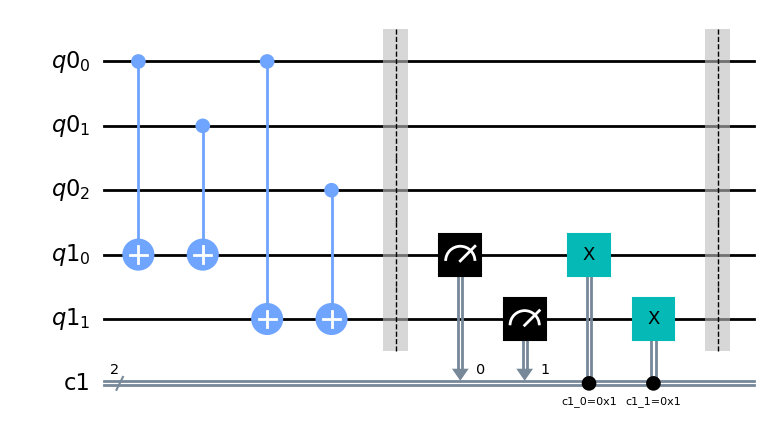

In [10]:
def measure_syndrome_bit(qc, qreg_data, qreg_measure, creg_measure):
    qc.cx(qreg_data[0], qreg_measure[0])
    qc.cx(qreg_data[1], qreg_measure[0])
    qc.cx(qreg_data[0], qreg_measure[1])
    qc.cx(qreg_data[2], qreg_measure[1])
    qc.barrier(*qreg_data, *qreg_measure)
    qc.measure(qreg_measure, creg_measure)
    qc.x(qreg_measure[0]).c_if(creg_measure[0], 1)
    qc.x(qreg_measure[1]).c_if(creg_measure[1], 1)
    qc.barrier(*qreg_data, *qreg_measure)
    return qc


qc_syndrome_bit = measure_syndrome_bit(
    build_qc(), qreg_data, qreg_measure, creg_syndrome
)
qc_syndrome_bit.draw(output="mpl", idle_wires=False)

We can do conditional measurements in Qiskit either with the old-style control flow `circuit.x(0).c_if(<condition>)`, or the new-style control-flow `with circuit.if_test(<condition>)`; [for more details, see here](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_else.html). In this tutorial, we are using the old-style control flow because of a temporary limitation with dynamic circuit scheduling support.

### Visualize our syndrome measurement

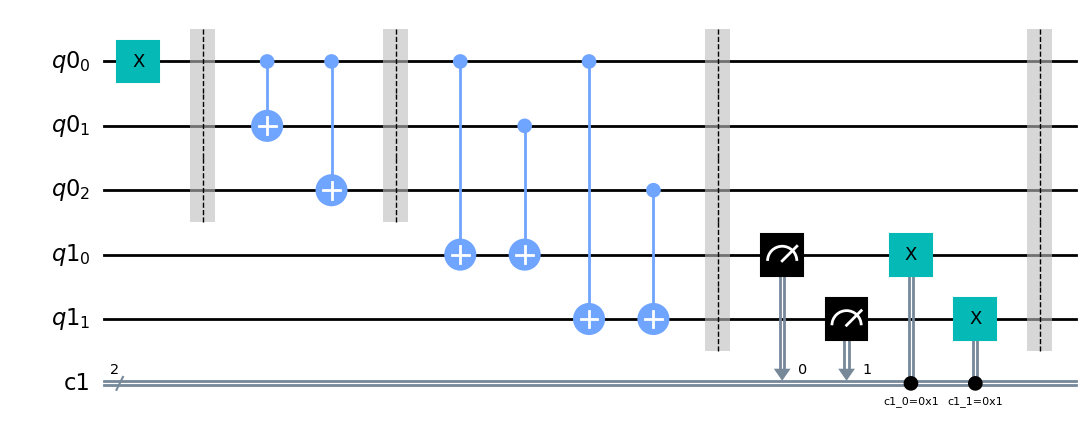

In [11]:
qc_measure_syndrome_bit = qc_encoded_state_bit.compose(qc_syndrome_bit)
qc_measure_syndrome_bit.draw(output="mpl", idle_wires=False)

## Decode and apply our correction sequence

Collectively measuring the stabilizers provides enough information to identify where a single X-flip error occurred.
- If we measure `IZZ=-1` and `ZIZ=1` the error ocurred on qubit 1
- If we measure `IZZ=1` and `ZIZ=-1` the error ocurred on qubit 2
- If we measure `IZZ=-1` and `ZIZ=-1` the error ocurred on qubit 0

The circuit below corrects our state in the case of a single bit-flip error: $$|\tilde{\Psi}_2\rangle \rightarrow |\tilde{\Psi}_1\rangle$$ 

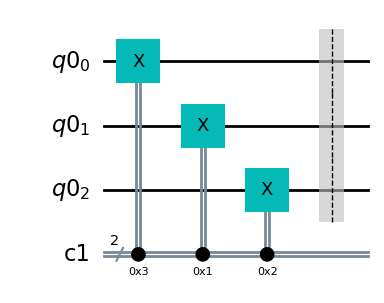

In [12]:
def apply_correction_bit(qc, qreg_data, creg_syndrome):
    qc.x(qreg_data[0]).c_if(creg_syndrome, 3)
    qc.x(qreg_data[1]).c_if(creg_syndrome, 1)
    qc.x(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    return qc


qc_correction_bit = apply_correction_bit(build_qc(), qreg_data, creg_syndrome)
qc_correction_bit.draw(output="mpl", idle_wires=False)

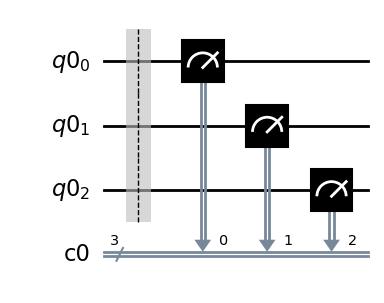

In [13]:
def apply_final_readout(qc, qreg_data, creg_data):
    qc.barrier(qreg_data)
    qc.measure(qreg_data, creg_data)
    return qc


qc_final_measure = apply_final_readout(build_qc(), qreg_data, creg_data)
qc_final_measure.draw(output="mpl", idle_wires=False)

## A complete cycle of the bit-flip code
We complete putting our building blocks together in the circuit below.

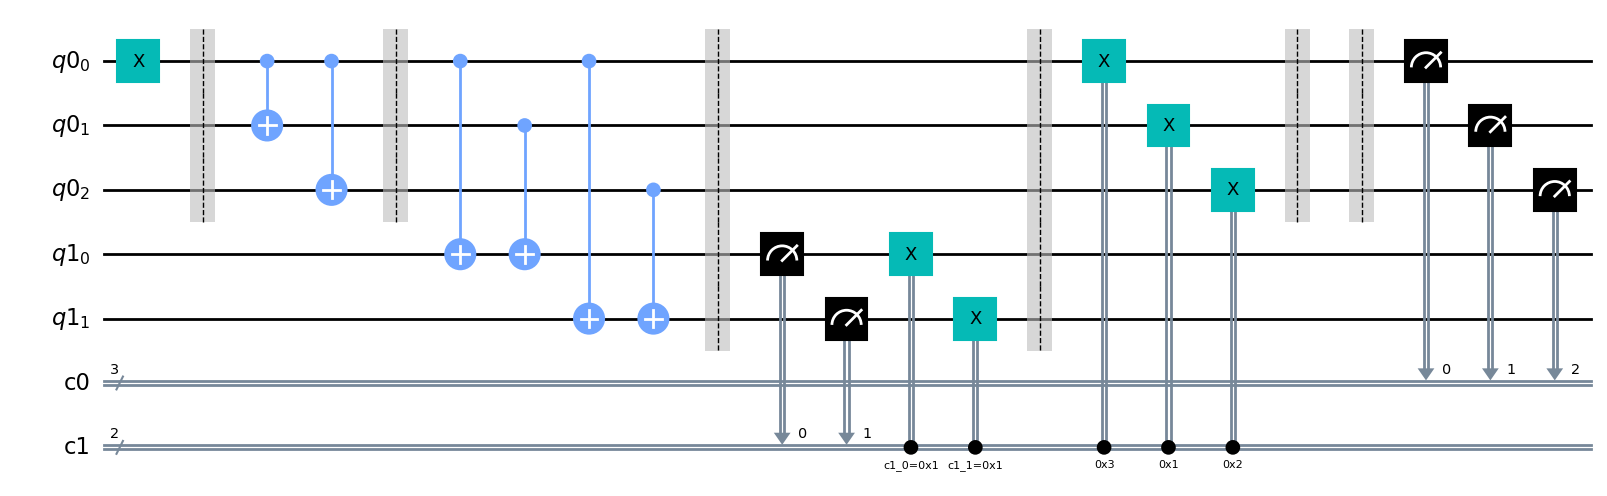

In [14]:
bit_code_circuit = qc_measure_syndrome_bit.compose(qc_correction_bit).compose(
    qc_final_measure
)
bit_code_circuit.draw(output="mpl", idle_wires=False)

## Create a routine to perform multiple cycles of parity checks
The routine below will allow us to easily compose multiple cycles of our code interspersed
by the error channels provided in `qc_channels`.

In [15]:
def build_error_correction_sequence(
    qc_base: QuantumCircuit,
    qc_init: Optional[QuantumCircuit],
    qc_encode: QuantumCircuit,
    qc_channels: List[QuantumCircuit],
    qc_syndrome: QuantumCircuit,
    qc_correct: QuantumCircuit,
    qc_decode: Optional[QuantumCircuit] = None,
    qc_final: Optional[QuantumCircuit] = None,
    name=None,
) -> QuantumCircuit:
    """Build a typical error correction circuit"""
    qc = qc_base

    if qc_init:
        qc = qc.compose(qc_init)

    qc = qc.compose(qc_encode)
    if name is not None:
        qc.name = name

    if not qc_channels:
        qc_channels = [QuantumCircuit(*qc.qregs)]

    for qc_channel in qc_channels:
        qc = qc.compose(qc_channel).compose(qc_syndrome).compose(qc_correct)
    if qc_decode:
        qc = qc.compose(qc_decode)

    if qc_final:
        qc = qc.compose(qc_final)

    return qc

For example, we can use this to replicate our bit-flip code from above:

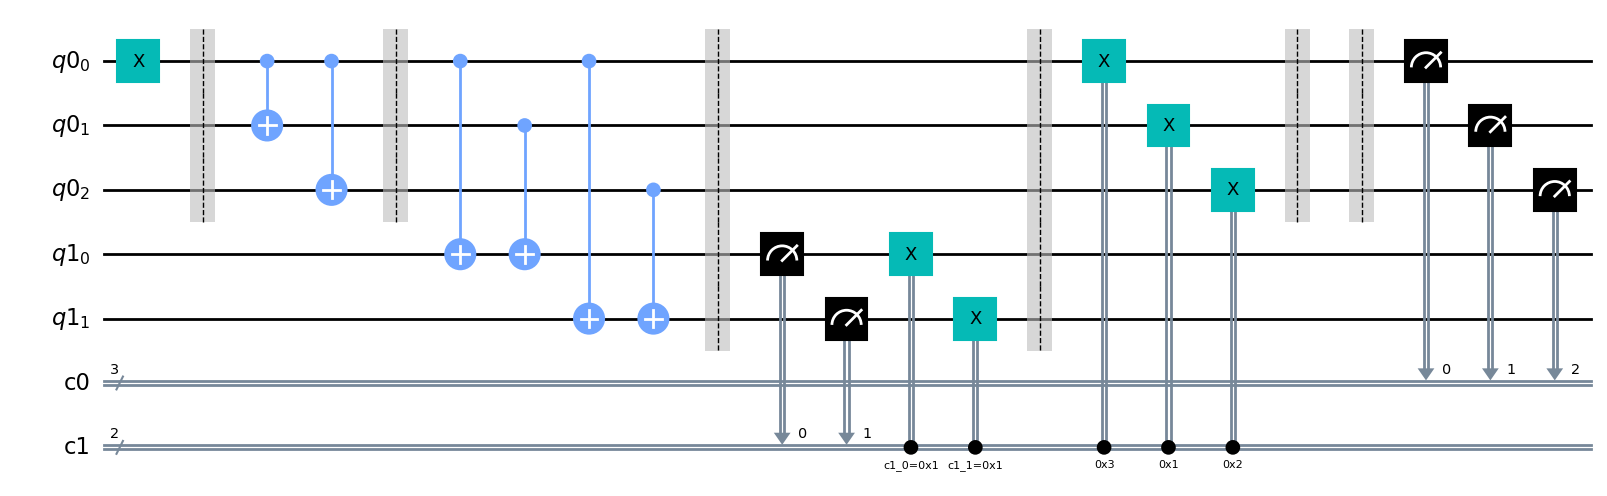

In [16]:
bit_code_circuit = build_error_correction_sequence(
    build_qc(),
    qc_init,
    qc_encode_bit,
    [],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
)
bit_code_circuit.draw(output="mpl", idle_wires=False)

## Run on hardware

We will now choose a qubit layout on the device and transpile our circuit to a realizable
circuit on the device. We will see that due to limited connectivity we will have to perform
qubit routing. As not all qubits are of equal quality, it is important to choose good sets of qubits
in the hardware.

In [17]:
# feel free to adjust the initial layout
print(initial_layout := [2, 1, 3, 4, 5])

[2, 1, 3, 4, 5]


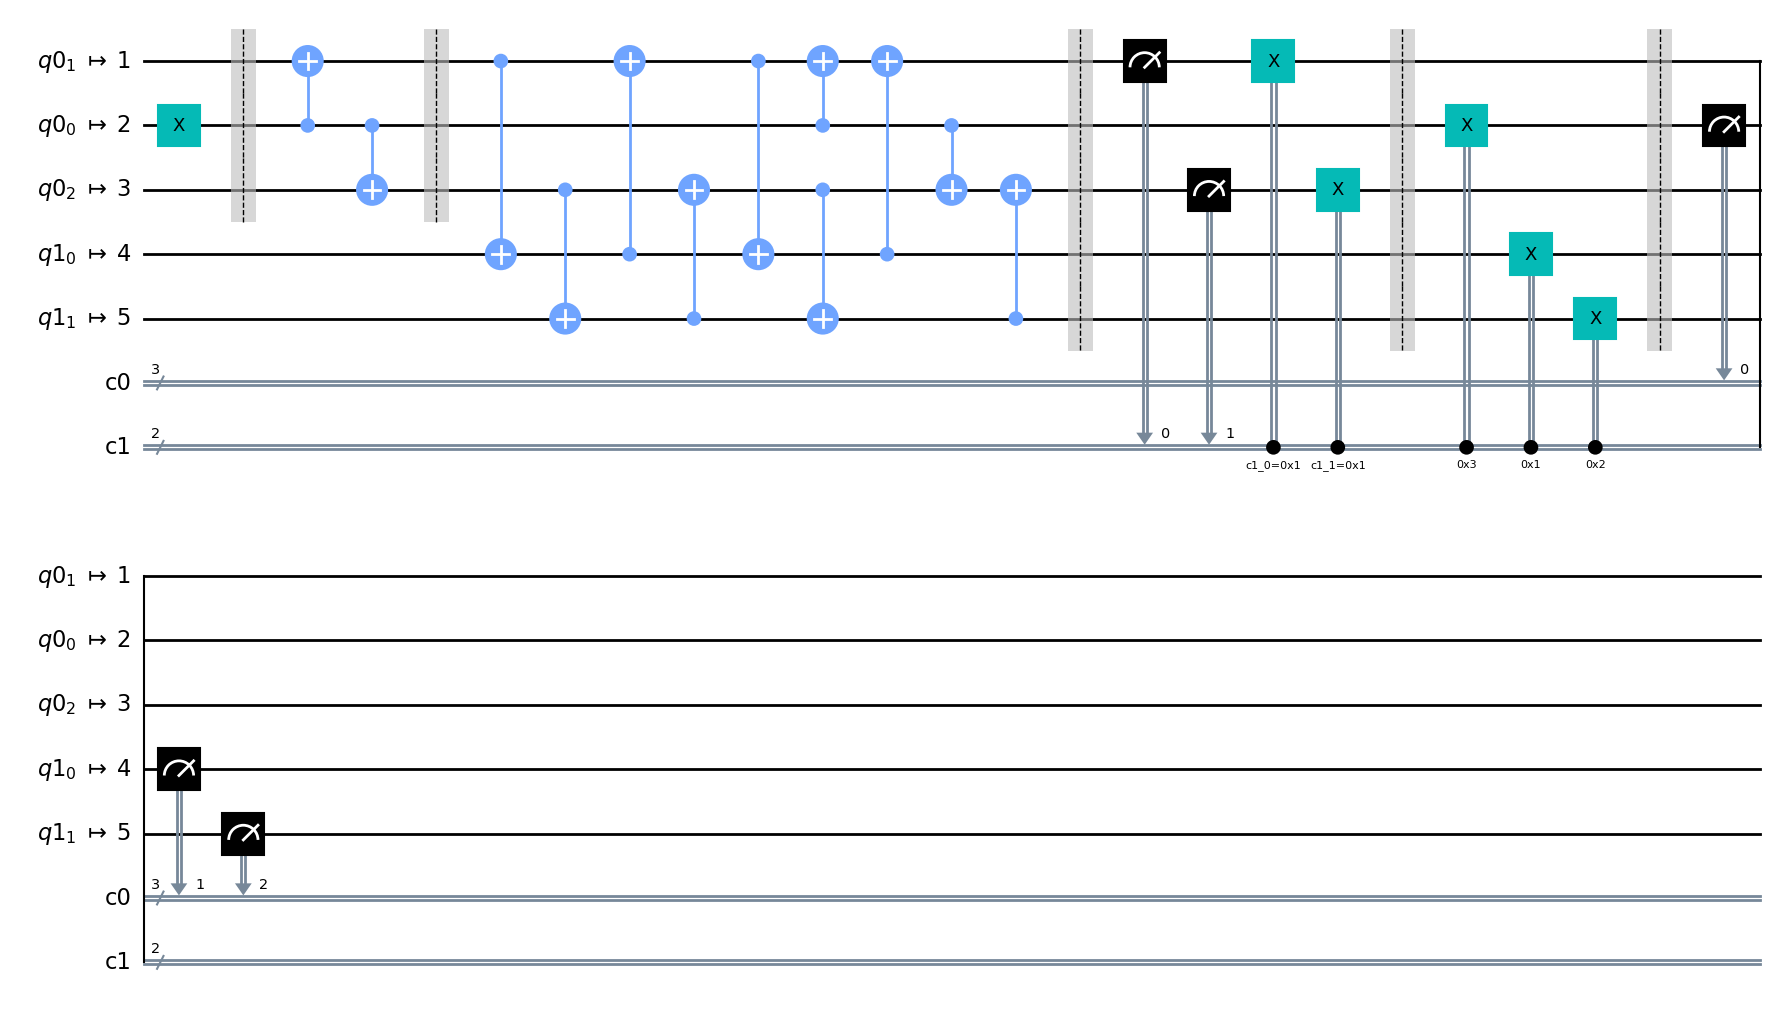

In [18]:
transpiled_bit_code_circuit = transpile(
    bit_code_circuit, backend, initial_layout=initial_layout
)
transpiled_bit_code_circuit.draw(output="mpl", idle_wires=False)

## Execute the circuit in hardware
Below we execute the circuit in the hardware and then decode the execution results.

In [19]:
job_bit_flip = backend.run(transpiled_bit_code_circuit, shots=shots, dynamic=True)
result_bit_flip = job_bit_flip.result()

In [20]:
def decode_result(data_counts, syndrome_counts, verbose=True, indent=0):
    shots = sum(data_counts.values())
    success_trials = data_counts.get("000", 0) + data_counts.get("111", 0)
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get("00", 0)

    if verbose:
        print(
            f"{' ' * indent}Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials"
        )
        print(
            f"{' ' * indent}A final parity error was detected on {failed_trials}/{shots} trials"
        )
    return error_correction_events, failed_trials


data_indices = list(range(len(qreg_data)))
syndrome_indices = list(range(data_indices[-1] + 1, len(qreg_data) + len(qreg_measure)))

marginalized_data_result = marginal_counts(result_bit_flip, data_indices)
marginalized_syndrome_result = marginal_counts(result_bit_flip, syndrome_indices)

print(
    f"Completed bit code experiment data measurement counts {marginalized_data_result.get_counts(0)}"
)
print(
    f"Completed bit code experiment syndrome measurement counts {marginalized_syndrome_result.get_counts(0)}"
)
decode_result(
    marginalized_data_result.get_counts(0), marginalized_syndrome_result.get_counts(0)
);

Completed bit code experiment data measurement counts {'000': 30, '001': 24, '010': 8, '011': 41, '100': 5, '101': 61, '110': 45, '111': 786}
Completed bit code experiment syndrome measurement counts {'00': 840, '10': 58, '11': 34, '01': 68}
Bit flip errors were detected/corrected on 160/1000 trials
A final parity error was detected on 184/1000 trials


## Emulate a random error source
Here we will use some more control flow to insert a random bit-flip error by using an ancilla qubit as a source of random bit-flips, and then look at the performance of our code.

In [21]:
from qiskit.circuit.library import IGate, XGate, ZGate

qreg_error_ancilla = QuantumRegister(1)
creg_error_ancilla = ClassicalRegister(1)


def build_random_error_channel(gate, ancilla, creg_ancilla, error_qubit):
    """Build an error channel that randomly applies a single-qubit gate based on an ancilla qubit measurement result"""
    qc = build_qc()
    qc.add_register(qreg_error_ancilla)
    qc.add_register(creg_error_ancilla)
    qc.barrier(ancilla, error_qubit.register)
    # 50-50 chance of applying a bit-flip
    qc.h(ancilla)
    qc.measure(ancilla, creg_ancilla)
    qc.append(gate, [error_qubit]).c_if(creg_ancilla, 1)
    qc.barrier(ancilla, error_qubit.register)
    return qc


qc_id_error_channel = build_random_error_channel(
    IGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0]
)
print("Identity error channel")
print(
    qc_id_error_channel.draw(idle_wires=False, output="text", fold=-1, cregbundle=False)
)

qc_bit_flip_error_channel = build_random_error_channel(
    XGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0]
)
print("Bit flip error channel")
print(
    qc_bit_flip_error_channel.draw(
        idle_wires=False, output="text", fold=-1, cregbundle=False
    )
)

qc_phase_flip_error_channel = build_random_error_channel(
    ZGate(), qreg_error_ancilla, creg_error_ancilla, qreg_data[0]
)
print("Phase flip error channel")
print(
    qc_phase_flip_error_channel.draw(
        idle_wires=False, output="text", fold=-1, cregbundle=False
    )
)

Identity error channel
       ░         ┌───┐ ░ 
q0_0: ─░─────────┤ I ├─░─
       ░ ┌───┐┌─┐└─╥─┘ ░ 
  q9: ─░─┤ H ├┤M├──╫───░─
       ░ └───┘└╥┘  ║   ░ 
  c2: ═════════╩═══■═════
                  0x1    
Bit flip error channel
       ░         ┌───┐ ░ 
q0_0: ─░─────────┤ X ├─░─
       ░ ┌───┐┌─┐└─╥─┘ ░ 
  q9: ─░─┤ H ├┤M├──╫───░─
       ░ └───┘└╥┘  ║   ░ 
  c2: ═════════╩═══■═════
                  0x1    
Phase flip error channel
       ░         ┌───┐ ░ 
q0_0: ─░─────────┤ Z ├─░─
       ░ ┌───┐┌─┐└─╥─┘ ░ 
  q9: ─░─┤ H ├┤M├──╫───░─
       ░ └───┘└╥┘  ║   ░ 
  c2: ═════════╩═══■═════
                  0x1    


## Inject the error into our error-correction sequence

In order to emulate a source of error, we add the error channel in between the encoding phase where we encode our qubit in the codespace, and the syndrome measurement phase where we measure the syndromes. In other words, we inject the error into our encoded logical state.

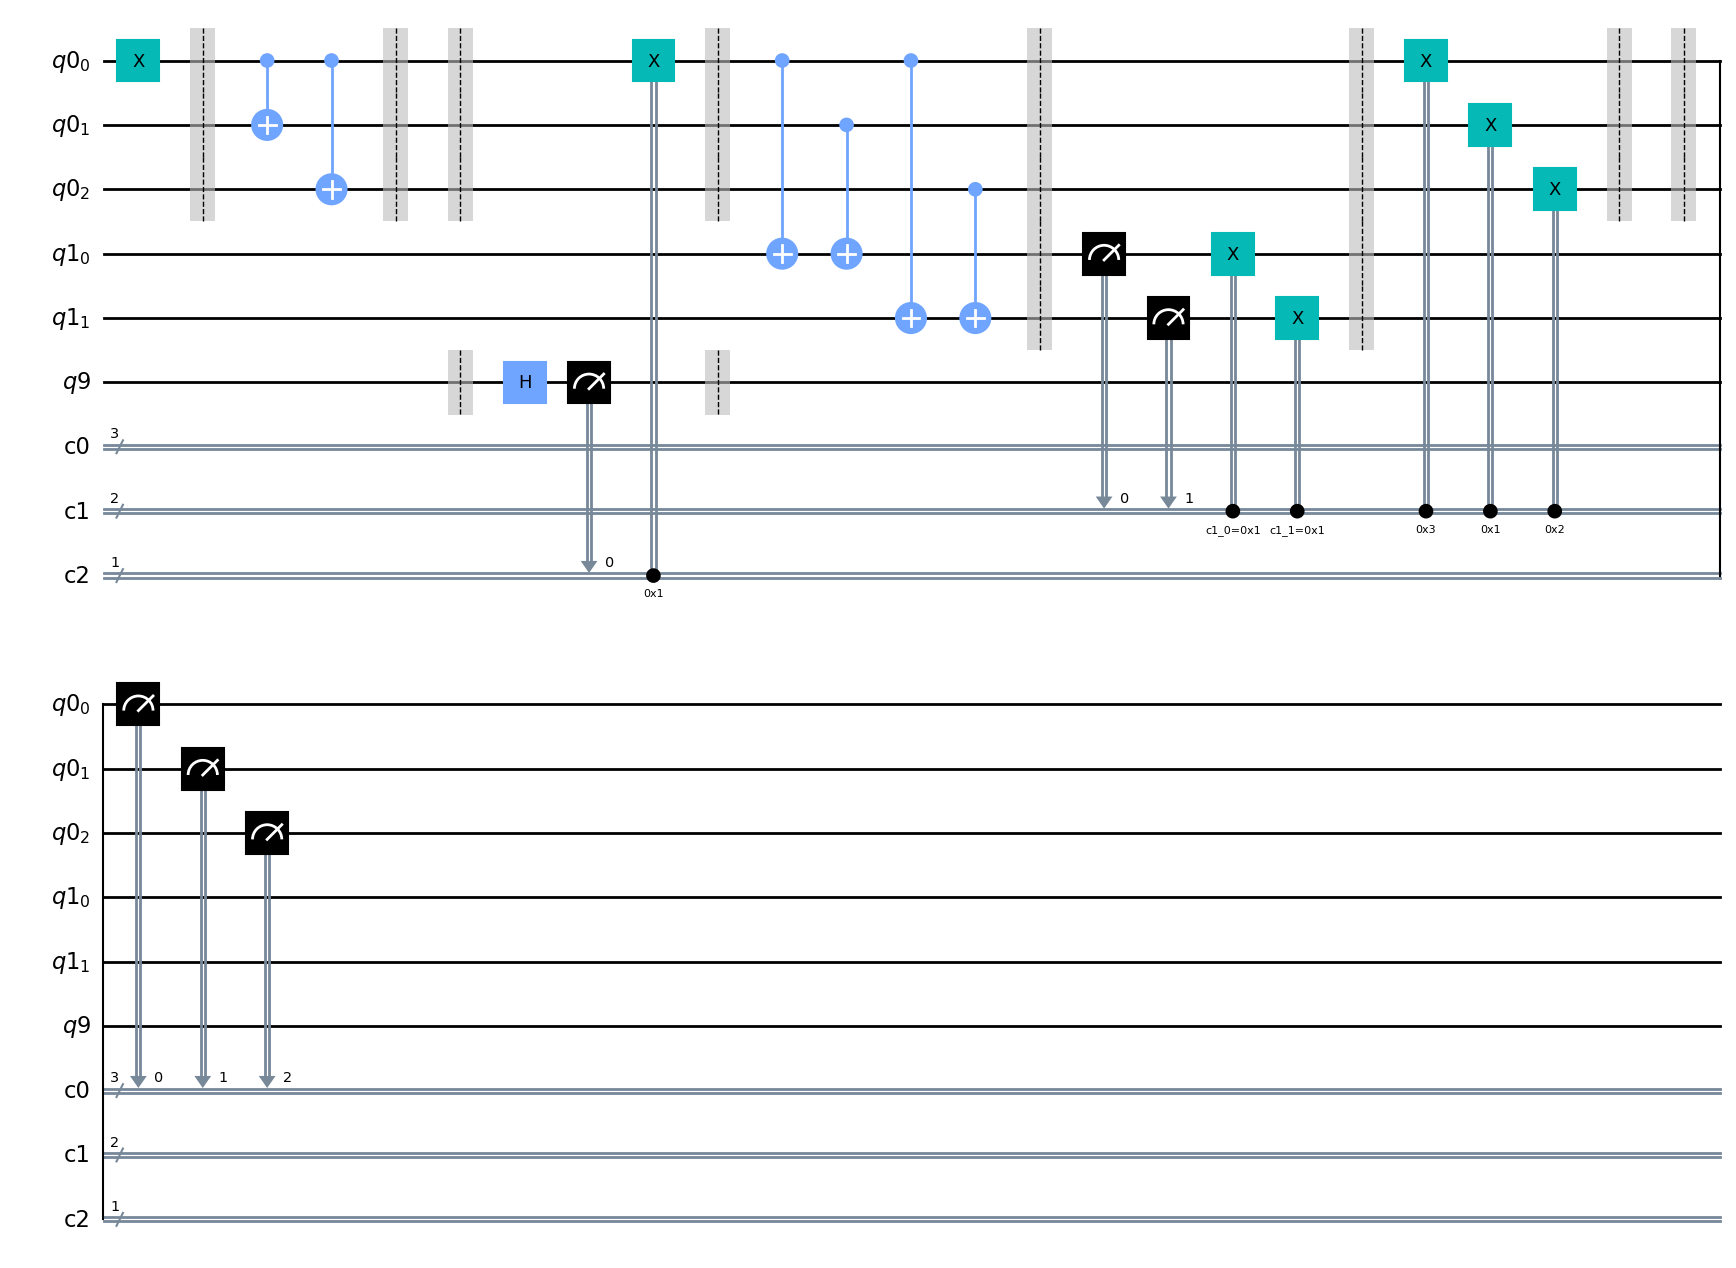

In [22]:
def build_error_channel_base():
    qc = build_qc()
    qc.add_register(qreg_error_ancilla)
    qc.add_register(creg_error_ancilla)
    return qc


qc_id_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_id_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Identity error channel",
)

qc_bit_flip_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_bit_flip_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Bit flip error channel",
)

qc_phase_flip_error_bit_flip_code = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_phase_flip_error_channel],
    qc_syndrome_bit,
    qc_correction_bit,
    None,
    qc_final_measure,
    "Phase flip error channel",
)

circuits_error_channels_bit_flip_code = [
    qc_id_error_bit_flip_code,
    qc_bit_flip_error_bit_flip_code,
    qc_phase_flip_error_bit_flip_code,
]

qc_bit_flip_error_bit_flip_code.draw(output="mpl", idle_wires=False)

## Execute the circuits

In [23]:
# We need to add an extra ancilla qubit to our layout
# It doesn't matter which qubit for the most part as we are using it as a
# source of random information
error_channel_layout = error_channel_layout = (
    initial_layout
    + list(
        set(range(circuits_error_channels_bit_flip_code[0].num_qubits))
        - set(initial_layout)
    )[:1]
)

transpiled_circuits_error_channels_bit_flip_code = transpile(
    circuits_error_channels_bit_flip_code, backend, initial_layout=error_channel_layout
)

job_error_channels_bit_flip_code = backend.run(
    transpiled_circuits_error_channels_bit_flip_code, shots=shots, dynamic=True
)
result_error_channels_bit_flip_code = job_error_channels_bit_flip_code.result()

In [24]:
def decode_error_channel_result(
    qc_init, data_counts, syndrome_counts, verbose=True, indent=0
):
    shots = sum(data_counts.values())
    success_trials = data_counts.get("000", 0) + data_counts.get("111", 0)
    failed_trials = shots - success_trials

    error_correction_events = shots - syndrome_counts.get("00", 0)

    if verbose:
        print(
            f"{' ' * indent}Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials"
        )
        print(
            f"{' ' * indent}A final parity error was detected on {failed_trials}/{shots} trials"
        )
    return error_correction_events, failed_trials

## Observe that we correct the majority of the bit-flip errors introduced
Note that injecting phase-flip errors has minimal impact on the final error outcome, because our qubit is in $\left|1\right\rangle$ input state, which is not sensitive to phase-flip errors. This is not the case for an arbitrary input state.

In [25]:
qc_init_outcome = qc_init.copy()
qc_init_outcome.measure(qreg_data[0], 0)

qreg_indices = list(range(len(qreg_data)))
data_indices = qreg_indices[:1]
syndrome_indices = list(range(qreg_indices[-1] + 1, len(qreg_data) + len(qreg_measure)))

result_decoded_data_qubit_marginal_err_ch = marginal_counts(
    result_error_channels_bit_flip_code, data_indices
)
result_data_marginal_err_ch = marginal_counts(
    result_error_channels_bit_flip_code, qreg_indices
)
result_syndrome_marginal_err_ch = marginal_counts(
    result_error_channels_bit_flip_code, syndrome_indices
)

for i, qc in enumerate(transpiled_circuits_error_channels_bit_flip_code):
    print(f"For {qc.name} with bit flip code")
    print(
        f"    Completed bit code experiment decoded data qubit measurement counts {result_decoded_data_qubit_marginal_err_ch.get_counts(i)}"
    )
    print(
        f"    Completed bit code experiment data qubits measurement counts {result_data_marginal_err_ch.get_counts(i)}"
    )
    print(
        f"    Completed bit code experiment syndrome measurement counts {result_syndrome_marginal_err_ch.get_counts(i)}"
    )
    decode_error_channel_result(
        qc_init_outcome,
        result_data_marginal_err_ch.get_counts(i),
        result_syndrome_marginal_err_ch.get_counts(i),
        indent=4,
    )
    print("")

For Identity error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'1': 921, '0': 79}
    Completed bit code experiment data qubits measurement counts {'111': 785, '001': 26, '011': 57, '110': 39, '101': 53, '000': 28, '010': 7, '100': 5}
    Completed bit code experiment syndrome measurement counts {'00': 829, '10': 56, '01': 78, '11': 37}
    Bit flip errors were detected/corrected on 171/1000 trials
    A final parity error was detected on 187/1000 trials

For Bit flip error channel with bit flip code
    Completed bit code experiment decoded data qubit measurement counts {'1': 889, '0': 111}
    Completed bit code experiment data qubits measurement counts {'111': 713, '101': 69, '001': 51, '011': 56, '100': 17, '110': 27, '010': 15, '000': 52}
    Completed bit code experiment syndrome measurement counts {'00': 411, '11': 400, '01': 97, '10': 92}
    Bit flip errors were detected/corrected on 589/1000 trials
    A final parity err

In the next sections of the tutorial, we evaluate the performance of bit-flip code.

## Compare our bit-flip code to a code that applies the *identity* correction

We will now create a decoding sequence that *does not* correct the error, but rather performs conditional identity operations.

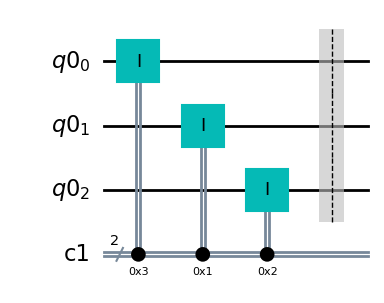

In [26]:
def apply_no_correction_bit(qc, qreg_data, creg_syndrome):
    """Apply an "identity correction"

    We need to make sure to still apply the conditional gates so that the comparison to the bit-flip
    code is faithful.
    """
    qc.id(qreg_data[0]).c_if(creg_syndrome, 3)
    qc.id(qreg_data[1]).c_if(creg_syndrome, 1)
    qc.id(qreg_data[2]).c_if(creg_syndrome, 2)
    qc.barrier(qreg_data)
    return qc


qc_no_correction_bit = apply_no_correction_bit(build_qc(), qreg_data, creg_syndrome)
qc_no_correction_bit.draw(output="mpl", idle_wires=False)

We implement circuits that *do not* correct the bit-flip errors, using the routine above.

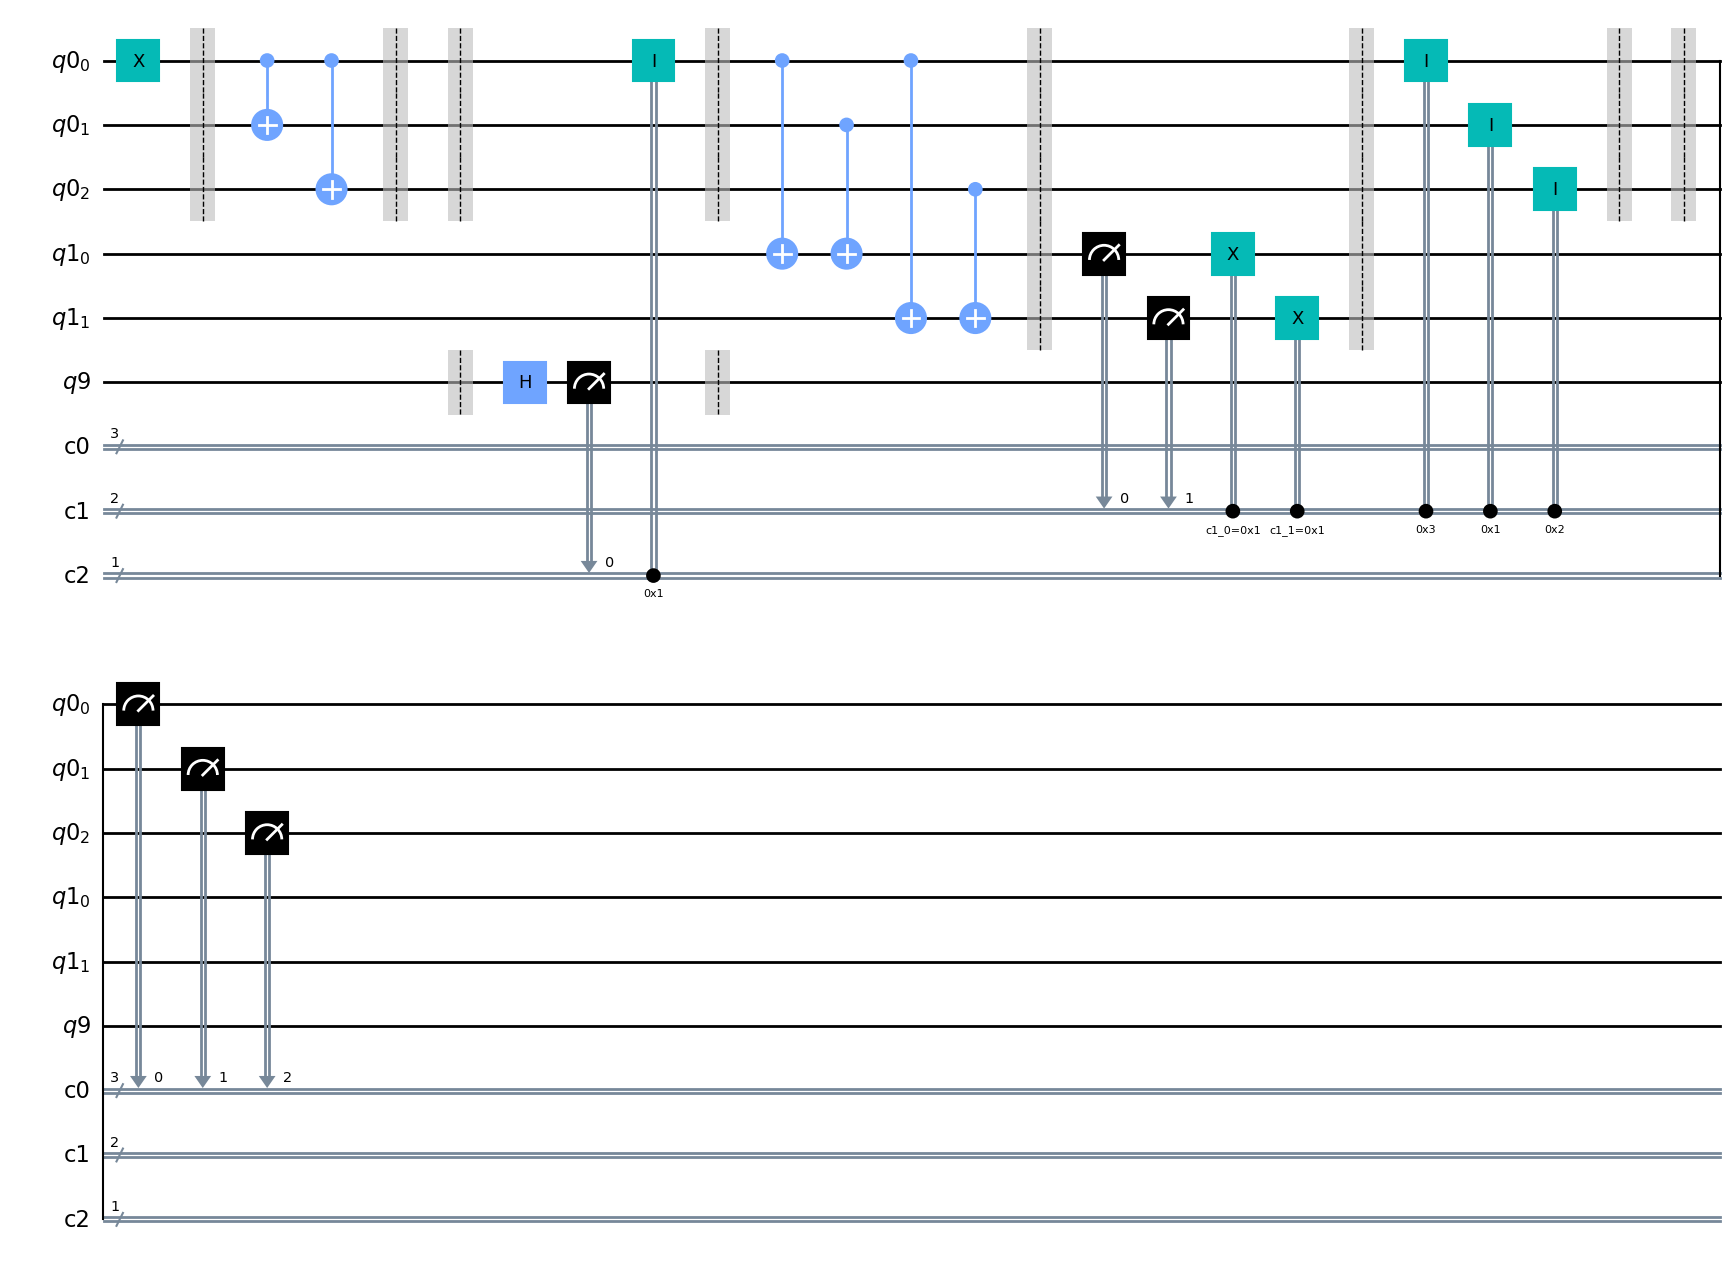

In [27]:
qc_id_error_no_correct = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_id_error_channel],
    qc_syndrome_bit,
    qc_no_correction_bit,
    None,
    qc_final_measure,
    "Identity error channel",
)

qc_bit_flip_error_no_correct = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_bit_flip_error_channel],
    qc_syndrome_bit,
    qc_no_correction_bit,
    None,
    qc_final_measure,
    "Bit flip error channel",
)

qc_phase_flip_error_no_correct = build_error_correction_sequence(
    build_error_channel_base(),
    qc_init,
    qc_encode_bit,
    [qc_phase_flip_error_channel],
    qc_syndrome_bit,
    qc_no_correction_bit,
    None,
    qc_final_measure,
    "Phase flip error channel",
)

circuits_error_channels_no_correct = [
    qc_id_error_no_correct,
    qc_bit_flip_error_no_correct,
    qc_phase_flip_error_no_correct,
]

qc_id_error_no_correct.draw(output="mpl", idle_wires=False)

We will now execute the circuits that *do not* perform a correction.

In [28]:
# We need to add an extra ancilla qubit to our layout
# It doesn't matter which qubit for the most part as we are using it as a
# source of random information
error_channel_layout = error_channel_layout = (
    initial_layout
    + list(
        set(range(circuits_error_channels_bit_flip_code[0].num_qubits))
        - set(initial_layout)
    )[:1]
)

transpiled_circuits_error_channels_no_correct = transpile(
    circuits_error_channels_no_correct, backend, initial_layout=error_channel_layout
)
job_error_channels_no_correct = backend.run(
    transpiled_circuits_error_channels_no_correct, shots=shots, dynamic=True
)
result_error_channels_no_correct = job_error_channels_no_correct.result()

The analysis below shows that the results are worse than that of the experiments where we indeed corrected the errors. We can see that the number of parity errors has increased significantly. 

In [29]:
qc_init_outcome = qc_init.copy()
qc_init_outcome.measure(qreg_data[0], 0)

qreg_indices = list(range(len(qreg_data)))
data_indices = qreg_indices[:1]
syndrome_indices = list(range(qreg_indices[-1] + 1, len(qreg_data) + len(qreg_measure)))

result_decoded_data_qubit_marginal_no_correct = marginal_counts(
    result_error_channels_no_correct, data_indices
)
result_data_marginal_no_correct = marginal_counts(
    result_error_channels_no_correct, qreg_indices
)
result_syndrome_marginal_no_correct = marginal_counts(
    result_error_channels_no_correct, syndrome_indices
)

for i, qc in enumerate(transpiled_circuits_error_channels_no_correct):
    print(f'For {qc.name} with "identity" correction')
    print(
        f"    Completed bit code experiment decoded data qubit measurement counts {result_decoded_data_qubit_marginal_no_correct.get_counts(i)}"
    )
    print(
        f"    Completed bit code experiment data qubits measurement counts {result_data_marginal_no_correct.get_counts(i)}"
    )
    print(
        f"    Completed bit code experiment syndrome measurement counts {result_syndrome_marginal_no_correct.get_counts(i)}"
    )
    decode_error_channel_result(
        qc_init_outcome,
        result_data_marginal_no_correct.get_counts(i),
        result_syndrome_marginal_no_correct.get_counts(i),
        indent=4,
    )
    print("")

For Identity error channel with "identity" correction
    Completed bit code experiment decoded data qubit measurement counts {'0': 34, '1': 966}
    Completed bit code experiment data qubits measurement counts {'000': 5, '101': 48, '111': 891, '110': 23, '100': 3, '011': 25, '001': 2, '010': 3}
    Completed bit code experiment syndrome measurement counts {'00': 907, '01': 55, '11': 13, '10': 25}
    Bit flip errors were detected/corrected on 93/1000 trials
    A final parity error was detected on 104/1000 trials

For Bit flip error channel with "identity" correction
    Completed bit code experiment decoded data qubit measurement counts {'0': 495, '1': 505}
    Completed bit code experiment data qubits measurement counts {'110': 436, '111': 456, '100': 25, '010': 26, '101': 25, '011': 17, '000': 8, '001': 7}
    Completed bit code experiment syndrome measurement counts {'00': 478, '10': 49, '11': 439, '01': 34}
    Bit flip errors were detected/corrected on 522/1000 trials
    A fina

## Evaluate the performance of multiple stabilizer cycles 

We will now evaluate multiple cycles of measuring the stabilizer and applying our correction sequence with the routines we have created above. 

We perform experiments on our bit-flip code circuit with/without error correction. In addition, we study equivalent idle quantum circuits in order to compare our performance with a raw physical qubit. Our idle circuits prepare our state, but *do not* perform encoding/decoding/correcting errors; they instead idle for the same period of time.

We will plot the performance (Hellinger fidelity) of our quantum circuits as a function of the number of stabilizer cycles. 

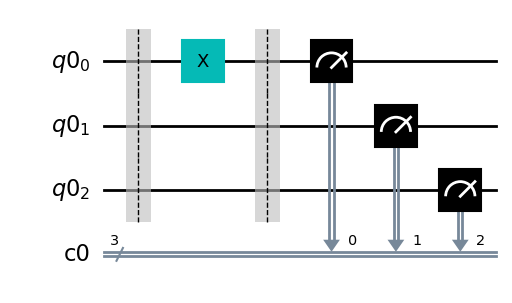

In [30]:
def apply_final_readout_invert(qc, qc_init, qreg_data, creg_data):
    """Apply inverse mapping so that we always try and measure |0> in the computational basis."""
    qc = qc.compose(qc_init.inverse())
    qc.barrier(qreg_data)
    qc.measure(qreg_data, creg_data)
    return qc


qc_final_measure_invert = apply_final_readout_invert(
    build_qc(), qc_init, qreg_data, creg_data
)
qc_final_measure_invert.draw(output="mpl", idle_wires=False)

In [31]:
from collections import defaultdict
from qiskit.transpiler import PassManager
from qiskit_ibm_provider.transpiler.passes.scheduling import (
    DynamicCircuitInstructionDurations,
    ALAPScheduleAnalysis,
)


def get_circuit_duration_(qc: QuantumCircuit) -> int:
    """Get duration of circuit in hardware cycles."""
    durations = DynamicCircuitInstructionDurations.from_backend(backend)
    pm = PassManager([ALAPScheduleAnalysis(durations)])
    pm.run(qc)
    node_start_times = pm.property_set["node_start_time"]

    block_durations = defaultdict(int)
    for inst, (block, t0) in node_start_times.items():
        block_durations[block] = max(block_durations[block], t0 + inst.op.duration)

    duration = sum(block_durations.values())

    return duration


def build_idle_error_correction_sequence(
    qc_base: QuantumCircuit,
    qc_init: Optional[QuantumCircuit],
    qc_encode: QuantumCircuit,
    qc_channels: List[QuantumCircuit],
    qc_syndrome: QuantumCircuit,
    qc_correct: QuantumCircuit,
    qc_decode: Optional[QuantumCircuit] = None,
    qc_final: Optional[QuantumCircuit] = None,
    initial_layout=initial_layout,
    name: str = None,
) -> QuantumCircuit:
    """Build a quantum circuit that idles for the period of the input error correction sequence."""
    qc = qc_base

    if qc_init:
        qc = qc.compose(qc_init)
    if name is not None:
        qc.name = name

    qc_idle_region = qc_base.copy()

    qc_idle_region.compose(qc_encode)

    if not qc_channels:
        qc_channels = [QuantumCircuit(*qc.qregs)]

    for qc_channel in qc_channels:
        qc_idle_region = (
            qc_idle_region.compose(qc_channel).compose(qc_syndrome).compose(qc_correct)
        )

    if qc_decode:
        qc_idle_region = qc_idle_region.compose(qc_decode)

    qc_idle_transpiled = transpile(
        qc_idle_region, backend, initial_layout=initial_layout, scheduling_method=None
    )
    idle_duration = get_circuit_duration_(qc_idle_transpiled)

    qc_idle = qc_base.copy()
    qc_idle.barrier()
    for qubit in qc_idle.qubits:
        qc_idle.delay(idle_duration, qubit, unit="dt")
    qc_idle.barrier()
    qc = qc.compose(qc_idle)

    if qc_final:
        qc = qc.compose(qc_final)

    return qc

We now create an "idle" error channel.

In [32]:
# a helper routine to calculate the idle cycles


def convert_cycles(time_in_seconds: float, backend) -> int:
    cycles = time_in_seconds / (backend.configuration().dt)
    return int(cycles + (16 - (cycles % 16)))

In [33]:
def build_idle_error_channel(time_in_seconds, qreg):
    idle_cycles = convert_cycles(time_in_seconds, backend)
    qc_idle = build_qc()
    qc_idle.delay(idle_cycles, qreg, "dt")
    qc_idle.barrier()
    return qc_idle

We will now perform a sweep of our bit-flip code circuit with/without error correction, and our equivalent idle circuit for a number of iterations.

In [34]:
num_rounds = 5

# Idle for a specified period in seconds
# This is how we build an idle error channel
idle_period = 5e-6

# Use the circuit we created above
qc_idle = build_idle_error_channel(idle_period, qreg_data)


qcs_corr_bit = []
qcs_no_corr_bit = []
qcs_idle_equiv_bit = []
for round_ in range(num_rounds):
    qc_error_channels = [qc_idle] * (round_ + 1)

    # bit-flip code with error correction
    qcs_corr_bit.append(
        build_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_bit,
            qc_error_channels,
            qc_syndrome_bit,
            qc_correction_bit,
            qc_decode_bit,
            qc_final_measure_invert,
            f"With Correction {round_}",
        )
    )

    # bit-flip code with no error correction (i.e., id error correction)
    qcs_no_corr_bit.append(
        build_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_bit,
            qc_error_channels,
            qc_syndrome_bit,
            qc_no_correction_bit,
            qc_decode_bit,
            qc_final_measure_invert,
            name=f"Without Correction {round_}",
        )
    )

    # equivalent idle circuit with no encoding/decoding/correcting errors
    qcs_idle_equiv_bit.append(
        build_idle_error_correction_sequence(
            build_qc(),
            qc_init,
            qc_encode_bit,
            qc_error_channels,
            qc_syndrome_bit,
            qc_correction_bit,
            qc_decode_bit,
            qc_final_measure_invert,
            initial_layout=initial_layout,
            name=f"Idle {round_}",
        )
    )

Below we execute and plot one of the circuits we constructed.

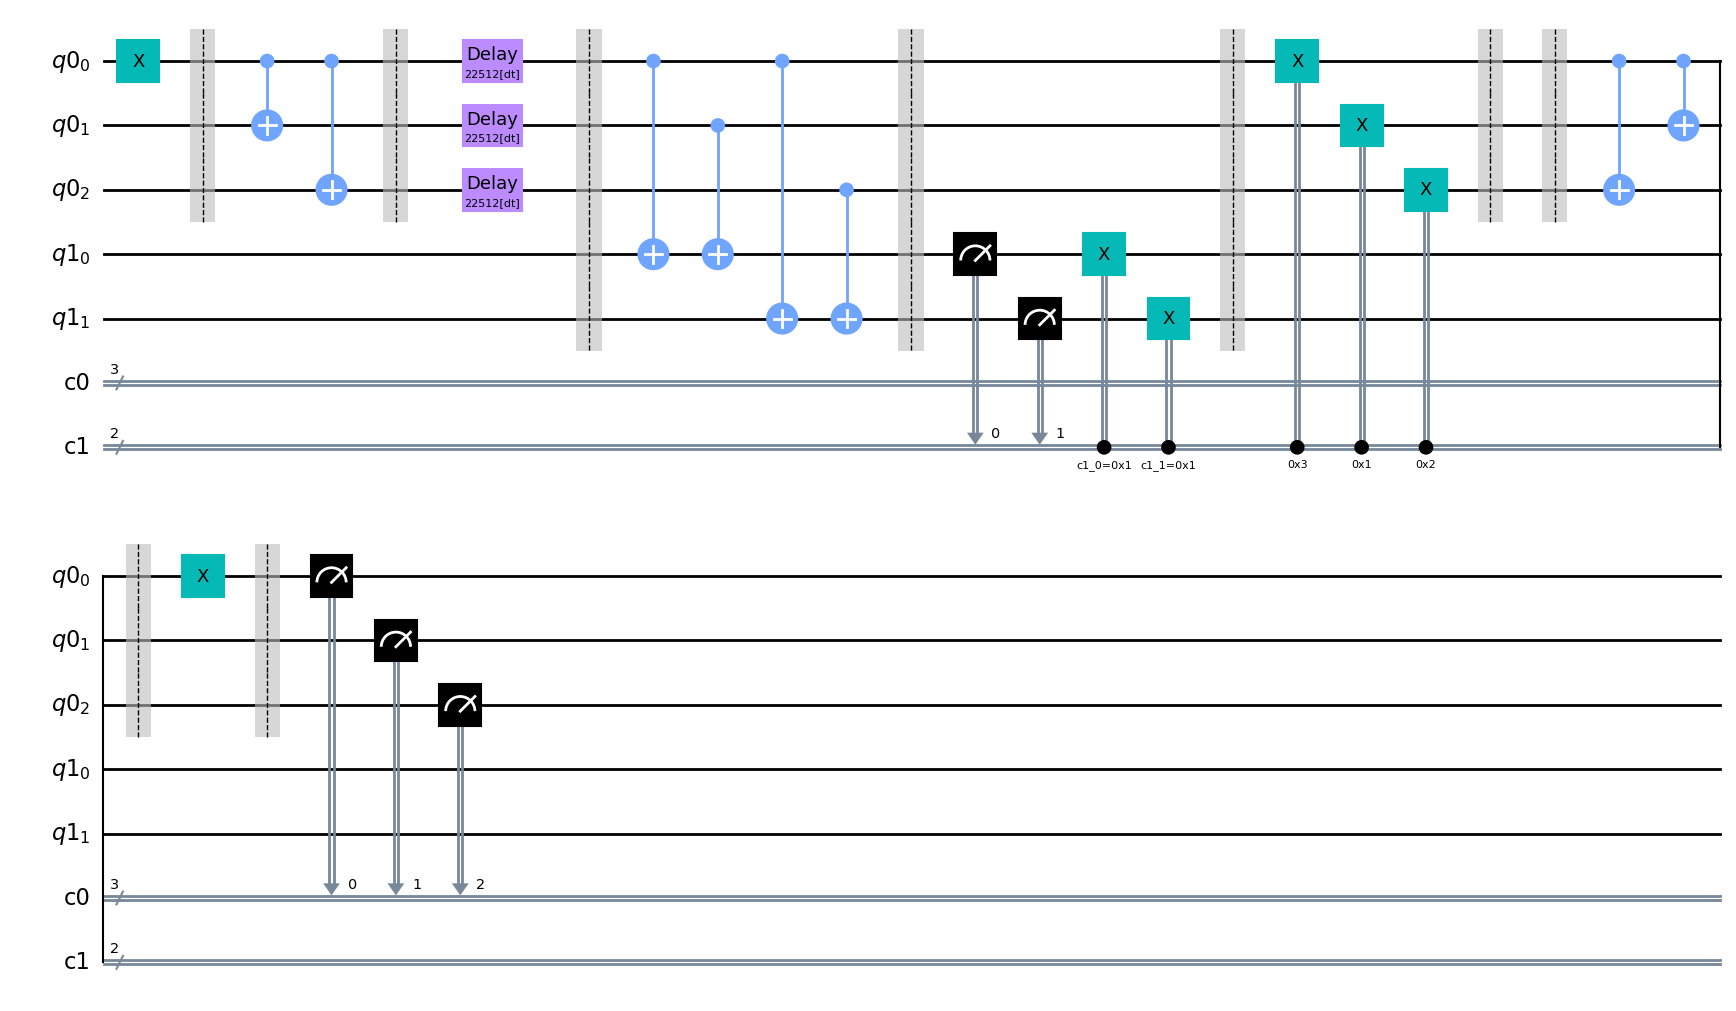

In [35]:
qcs_corr_bit[0].draw(output="mpl", idle_wires=False)

In [36]:
transpiled_qcs_corr_bit = transpile(
    qcs_corr_bit, backend, initial_layout=initial_layout
)
job_qcs_corr_bit = backend.run(transpiled_qcs_corr_bit, shots=shots, dynamic=True)

transpiled_qcs_no_corr_bit = transpile(
    qcs_no_corr_bit, backend, initial_layout=initial_layout
)
job_qcs_no_corr_bit = backend.run(transpiled_qcs_no_corr_bit, shots=shots, dynamic=True)

transpiled_qcs_idle_equiv_bit = transpile(
    qcs_idle_equiv_bit, backend, initial_layout=initial_layout
)
job_qcs_idle_equiv_bit = backend.run(
    transpiled_qcs_idle_equiv_bit, shots=shots, dynamic=True
)

result_qcs_corr_bit = job_qcs_corr_bit.result()
result_qcs_no_corr_bit = job_qcs_no_corr_bit.result()
result_qcs_idle_equiv_bit = job_qcs_idle_equiv_bit.result()

We use the ideal simulator below in calculating the fidelities.

In [37]:
from qiskit.providers.aer import Aer

ideal_sim = Aer.get_backend("qasm_simulator")

In [38]:
from qiskit.quantum_info.analysis import hellinger_fidelity

qc_init_outcome = qc_init.copy()
qc_init_outcome = qc_init_outcome.compose(qc_final_measure_invert)
transpiled_ideal = transpile(qc_init_outcome, backend, initial_layout=initial_layout)
result_ideal = ideal_sim.run(transpiled_ideal, shots=shots).result()


# Calculate the fidelity of our experiment given the ideal results obtained from our ideal simulator
def calculate_hellinger_fidelity(result_ideal, result_experiment, data_qubit=0):
    result_ideal = marginal_counts(result_ideal, indices=[data_qubit])
    result_experiment = marginal_counts(result_experiment, indices=[data_qubit])

    counts_ideal = result_ideal.get_counts(0)

    hellinger_fidelities = []
    for circuit_idx in range(len(result_experiment.results)):
        hellinger_fidelities.append(
            hellinger_fidelity(counts_ideal, result_experiment.get_counts(circuit_idx))
        )

    return hellinger_fidelities

We use the routuine `calculate_hellinger_fidelity` above to extract the Hellinger fidelity for our sweeps.

In [39]:
fidelities_corr_bit = calculate_hellinger_fidelity(result_ideal, result_qcs_corr_bit)
fidelities_no_corr_bit = calculate_hellinger_fidelity(
    result_ideal, result_qcs_no_corr_bit
)
fidelities_idle_equiv_bit = calculate_hellinger_fidelity(
    result_ideal, result_qcs_idle_equiv_bit
)

Finally, we plot the performance of our error-correcting code as a function of the number of iterations.

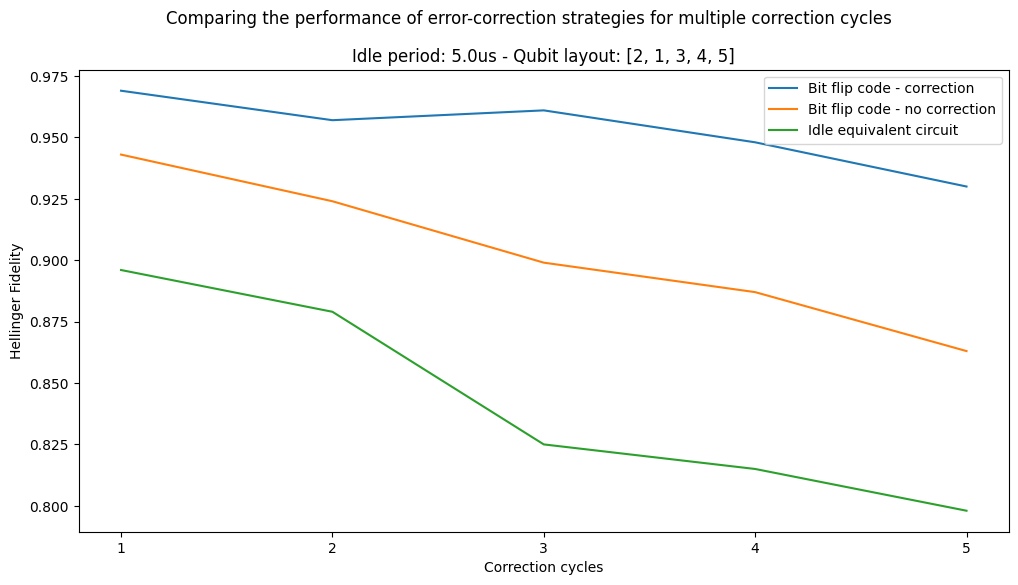

In [40]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

iters = range(1, num_rounds + 1)
plt.plot(iters, fidelities_corr_bit, label="Bit flip code - correction")
plt.plot(iters, fidelities_no_corr_bit, label="Bit flip code - no correction")
plt.plot(iters, fidelities_idle_equiv_bit, label="Idle equivalent circuit")
plt.ylabel("Hellinger Fidelity")
plt.xlabel("Correction cycles")
plt.xticks(iters)
plt.suptitle(
    "Comparing the performance of error-correction strategies for multiple correction cycles"
)
plt.title(f"Idle period: {idle_period*1e6}us - Qubit layout: {initial_layout}")
plt.legend(loc="upper right")

## Discussion/summary

In this tutorial, we learned how to perform a very simple form of QEC with dynamic circuits. We prepared a qubit in $\left|1\right\rangle$ state and showed that with a bit-flip code circuit we can detect/correct errors.

We expect the bit-flip code to perform the best with a $\left|1\right\rangle$ input state. Selecting a different input state, for example $\left|+\right\rangle$, will most likely lead to lower performance because of higher sensitivity to various types of error/noise. For example, as mentioned earlier in the notebook, $\left|1\right\rangle$ is not sensitive to phase errors, while this is not the case for the $\left|+\right\rangle$ state.

The important data to note is the average quality of protecting *any* input state. Please feel free to re-run this notebook, but instead of initializing with the $\left|1\right\rangle$ state, select a different state, and evaluate the performance of protecting different input states.

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table